In [4]:
import pandas as pd

# loading the dataset
x_train = pd.read_csv('CompleteDataset/x_train_all.csv')
y_train = pd.read_csv('CompleteDataset/y_train_all.csv')
x_test = pd.read_csv('CompleteDataset/x_test_all.csv')
y_test = pd.read_csv('CompleteDataset/y_test_all.csv')

In [5]:
# performs z-normalization on our dataset

# normalize x_train
mean=x_train.mean()
std=x_train.std()
x_train_norm=(x_train-mean)/std

# normalize x_test
mean=x_test.mean()
std=x_test.std()
x_test_norm=(x_test-mean)/std

In [6]:
from sklearn.ensemble import IsolationForest

# uses isolation forest algorithm to find outliers

feature_names = [f'{str(col)}' for col in x_train.columns]
x_train_norm.columns = feature_names

x_train_norm_copy = x_train_norm.copy()
contamination = 0.41
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(x_train_norm_copy)

outlier_indices = x_train_norm_copy.index[outliers == -1]

x_train_no_outliers_norm = x_train_norm_copy.drop(outlier_indices)
x_train_no_outliers_norm.to_csv('x_train_no_outliers_norm.csv')

outlier_indices_df = pd.DataFrame({'outlier_index_norm': outlier_indices})
outlier_indices_df.to_csv('outlier_indices_norm.csv', index=False)

In [7]:
# applies outlier mining to y train

# loads the indices to be removed from the dataset
indices_to_remove_norm = pd.read_csv('outlier_indices_norm.csv')

# removes outliers found after normalizing from y train
y_train_filtered_outlier_norm = y_train[~y_train.index.isin(indices_to_remove_norm['outlier_index_norm'])]

# saves to csv for future use
y_train_filtered_outlier_norm.to_csv('y_train_filtered_outlier_norm.csv')

In [8]:
# load y train without outliers
y_train_filtered_outlier_norm=pd.read_csv('y_train_filtered_outlier_norm.csv')

# drop previous indices
y_train_filtered_outlier_norm.drop('Unnamed: 0',axis=1, inplace=True)

In [9]:
from sklearn.ensemble import IsolationForest

# uses isolation forest algorithm to find outliers

feature_names = [f'{str(col)}' for col in x_test.columns]
x_test_norm.columns = feature_names

x_test_norm_copy = x_test_norm.copy()
contamination = 0.41
iso_forest = IsolationForest(contamination=contamination, random_state=42)

outliers = iso_forest.fit_predict(x_test_norm_copy)

outlier_indices = x_test_norm_copy.index[outliers == -1]

x_test_no_outliers_norm = x_test_norm_copy.drop(outlier_indices)
x_test_no_outliers_norm.to_csv('x_test_no_outliers_norm.csv')

outlier_indices_df_test = pd.DataFrame({'outlier_index_norm_test': outlier_indices})
outlier_indices_df_test.to_csv('outlier_indices_norm_test.csv', index=False)

In [10]:
# applies outlier mining to y test

# loads the indices to be removed from the dataset
indices_to_remove_norm_test = pd.read_csv('outlier_indices_norm_test.csv')

# removes outliers found after normalizing from y train
y_test_filtered_outlier_norm = y_test[~y_test.index.isin(indices_to_remove_norm_test['outlier_index_norm_test'])]

# saves to csv for future use
y_test_filtered_outlier_norm.to_csv('y_test_filtered_outlier_norm.csv')

In [11]:
# load y train without outliers
y_test_filtered_outlier_norm=pd.read_csv('y_test_filtered_outlier_norm.csv')

# drop previous indices
y_test_filtered_outlier_norm.drop('Unnamed: 0',axis=1, inplace=True)

In [12]:
# functions for getting performance metrics

import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_curve,
    roc_auc_score,
    auc
)

# runs the given fitted classifier with the given test data, outputs some performance metrics
def get_metrics_simple(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")

    # plotting the confusion matrix 
    out=ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    out.plot()
    plt.show()
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)

# fits and runs the given classifier with the given train and test data, outputs performance metrics
def get_metrics(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    y_pred_probs = clf.predict_proba(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")
    # finding the roc
    Y_test_bin = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7,8,9])
    roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
    # plotting the AUC graph
    auc_val = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    # plotting the confusion matrix 
    out=ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    out.plot()
    plt.show()
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall/Sensitivity/True Positive Rate:", recall)
    # print("False Positive Rate:", fpr)
    print("Area under ROC curve:", roc)
    print("Confusion Matrix:\n", conf_matrix)

In [13]:
# return performance metrics as an array
def get_metrics_array(clf, x_test, y_test):
    # transform pandas dataset to a 1d numpy array
    # y_test = y_test.to_numpy().ravel()

    y_pred = clf.predict(x_test)
    y_pred_probs = clf.predict_proba(x_test)
    # finding the accuracy
    accuracy = accuracy_score(y_test,y_pred )
    # finding the f1
    f1 = f1_score(y_pred, y_test, average="weighted")
    # finding the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    # finding the precision
    precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
    # finding the recall
    recall = recall_score(y_test, y_pred, average="weighted")
    # finding the roc
    Y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
    # plotting the AUC graph
    # print("Option: ", name)
    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % roc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('ROC Curve')
    # plt.legend(loc="lower right")
    # plt.show()
    # # plotting the confusion matrix 
    # out = ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
    # out.plot()
    # plt.show()
    # print("\n\n")
    return [accuracy, f1, precision, recall, roc]

In [14]:
def multi_get_metrics(names, clfs, x_test, y_test):
    results = {
        "name": [],
        "accuracy": [],
        "f1": [],
        "precision": [],
        "recall": [],
        "fpr": [],
        "roc": [],
        "confusion_matrix": []
    }
    for i in range(len(names)):
        clf = clfs[i]
        name = names[i]
        # transform pandas dataset to a 1d numpy array
        # y_test = y_test.to_numpy().ravel()

        y_pred = clf.predict(x_test)
        y_pred_probs = clf.predict_proba(x_test)
        # finding the accuracy
        accuracy = accuracy_score(y_test,y_pred )
        # finding the f1
        f1 = f1_score(y_pred, y_test, average="weighted")
        # finding the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        # finding the precision
        precision = precision_score(y_test, y_pred, average="weighted",zero_division=1)
        # finding the recall
        recall = recall_score(y_test, y_pred, average="weighted")
        # finding the roc
        Y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        roc = roc_auc_score(Y_test_bin, y_pred_probs, multi_class="ovr", average="weighted")

        fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_probs.ravel())
        # plotting the AUC graph
        # print("Option: ", name)
        # plt.figure()
        # plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC (area = %0.2f)' % roc)
        # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('ROC Curve')
        # plt.legend(loc="lower right")
        # plt.show()
        # # plotting the confusion matrix 
        # out = ConfusionMatrixDisplay(conf_matrix,display_labels=clf.classes_)
        # out.plot()
        # plt.show()
        # print("\n\n")
        results["name"].append(name)
        results["accuracy"].append(accuracy)
        results["f1"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["fpr"].append(fpr)
        results["roc"].append(roc)
        results["confusion_matrix"].append(conf_matrix)
    results_df = pd.DataFrame(results)
    results_df.drop(columns=["fpr", "confusion_matrix"], inplace=True)
    return results_df

    

In [15]:
# functions for cross-validation and 

import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import(
    StratifiedKFold,
    cross_val_score,
    cross_val_predict
)

# fits and runs the given classifier with the given train data and cross validation, outputs some performance metrics
def get_cross_val_metrics_simple(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    y_train = y_train.to_numpy().ravel()

    # Perform 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validation accuracy scores
    print("Cross-validation accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("Accuracy standard deviation:", cv_scores.std())

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightgreen')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

# fits and runs the given classifier with the given train data and cross validation, outputs performance metrics
def get_cross_val_metrics(clf, x_train, y_train):
    # transform pandas dataset to a 1d numpy array
    # y_train = y_train.to_numpy().ravel()

    # Perform 10-fold cross-validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, x_train, y_train, cv=cv, scoring='accuracy')

    # Print the cross-validation accuracy scores
    print("Cross-validation accuracy scores:", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("Accuracy standard deviation:", cv_scores.std())

    # Plotting the cross-validation scores
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(cv_scores)), cv_scores, color='lightgreen')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

    # Get predicted y_train for each fold
    y_pred = cross_val_predict(clf, x_train, y_train, cv=cv)

    # Compute overall precision, recall, F1 score, and support (unused)
    precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average='macro')

    # Print overall metrics
    print("Overall Precision:", precision)
    print("Overall Recall:", recall)
    print("Overall F1 Score:", f1)

    # Initialize variables to store overall metrics and confusion matrix
    overall_conf_matrix = np.zeros((len(np.unique(y_train)), len(np.unique(y_train))))

    # Loop over each fold
    for i, (train_idx, test_idx) in enumerate(cv.split(x_train, y_train)):
        X_train, X_test = x_train.iloc[train_idx], x_train.iloc[test_idx]
        Y_train, Y_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Fit the classifier
        clf.fit(X_train, Y_train)

        # Predict on the test set
        y_fold_pred = clf.predict(X_test)

        # Compute and plot confusion matrix
        conf_matrix = confusion_matrix(Y_test, y_fold_pred)
        overall_conf_matrix += conf_matrix

    # Calculate and print average confusion matrix
    y_train_annot = list(np.unique(np.array(y_train)))
    avg_conf_matrix = overall_conf_matrix / 10
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_conf_matrix, annot=True, fmt=".2f", xticklabels=y_train_annot, yticklabels=y_train_annot)
    plt.title("Average Confusion Matrix")
    plt.xlabel("Predicted y_train")
    plt.ylabel("Actual y_train")
    plt.show()

    X = x_train.values  # Convert DataFrame to NumPy array
    y = y_train.values  # Convert DataFrame to NumPy array

    y_scores = np.zeros((len(y), len(np.unique(y))))

    for train, test in cv.split(X, y):
        clf.fit(X[train], y[train])
        y_scores[test] = clf.predict_proba(X[test])

    # Compute overall ROC-AUC score
    roc_auc = roc_auc_score(label_binarize(y, classes=np.unique(y)), y_scores, average='macro')

    # Print overall ROC-AUC score
    print("Overall ROC-AUC:", roc_auc)

def plot_learning_curve(clf, x_train, y_train):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores, val_scores = [], []

    for size in train_sizes:
        sample_size = int(len(x_train) * size)
        train_score = np.mean(cross_val_score(clf, x_train[:sample_size], y_train[:sample_size], cv=10))
        train_scores.append(train_score)
        val_score = np.mean(cross_val_score(clf, x_train, y_train, cv=10))
        val_scores.append(val_score)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(x_train), train_scores, 'o-', color="red", label="Training score")
    plt.plot(train_sizes * len(x_train), val_scores, 'o-', color="green", label="Cross-validation score")

    plt.title("Learning Curve")
    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

    print("Average Training Score:", sum(train_scores)/10 )
    print("Average Cross-Validation Score:",sum(val_scores)/10)

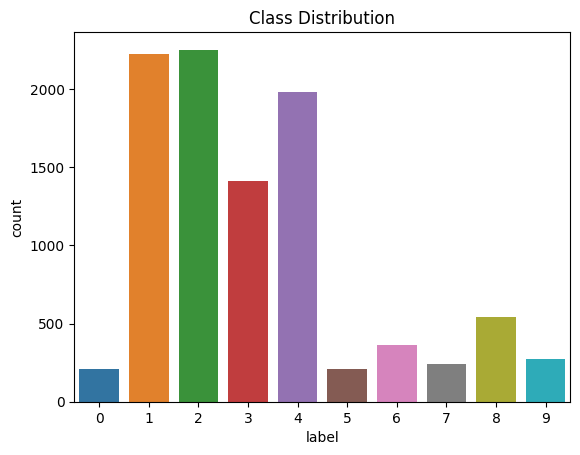

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# makes a bar graph counting the number of instances for each label
sns.countplot(data=y_train, x='0')
plt.xlabel("label")
plt.title('Class Distribution')
plt.show()

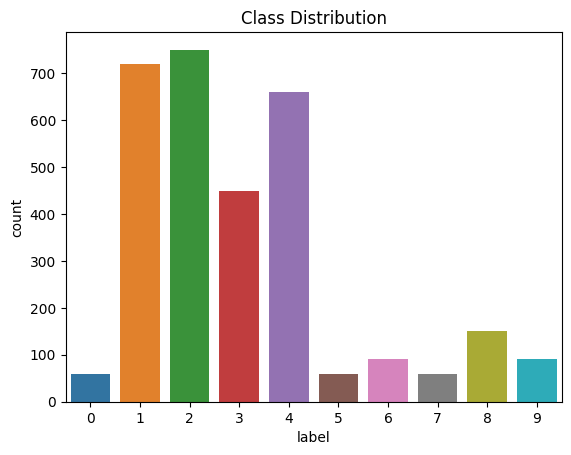

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# makes a bar graph counting the number of instances for each label
sns.countplot(data=y_test, x='0')
plt.xlabel("label")
plt.title('Class Distribution')
plt.show()

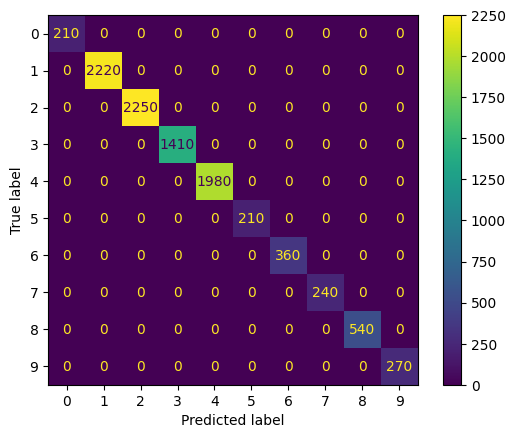

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall/Sensitivity/True Positive Rate: 1.0


In [121]:
# run a linear svm classifier on training set to check for linear separability

from sklearn.svm import SVC

svm = SVC(kernel="linear", random_state=42)
svm.fit(x_train, y_train.to_numpy().ravel())
get_metrics_simple(svm, x_train, y_train)

In [95]:
# linear svm classifier on validation set
get_metrics_simple(svm, x_test, y_test)

Accuracy: 0.8540453074433657
F1 Score: 0.8552576711876156
Precision: 0.8579061583577202
Recall/Sensitivity/True Positive Rate: 0.8540453074433657


In [122]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import (
    LogisticRegression,
    Perceptron,
)

perceptron_clf = Perceptron(random_state=42, class_weight="balanced")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
perceptron_clf_calibrated = CalibratedClassifierCV(perceptron_clf, cv=cv)

In [123]:
# learning curve for perceptron
perceptron_test = Perceptron(random_state=42, class_weight="balanced")
plot_learning_curve(perceptron_test, x_train, y_train.to_numpy().ravel())

Average Training Score: 0.8571546454618719
Average Cross-Validation Score: 0.8176470588235294


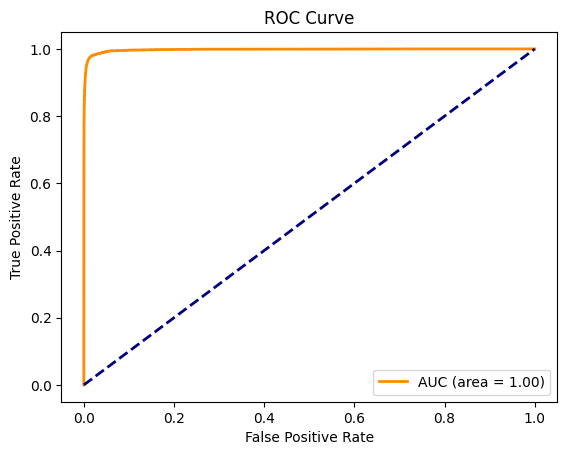

Accuracy: 0.956140350877193
F1 Score: 0.956217842264224
Precision: 0.9565995641836605
Recall/Sensitivity/True Positive Rate: 0.956140350877193
False Positive Rate: [0.         0.         0.         ... 0.71844972 0.71844972 1.        ]
Area under ROC curve: 0.9950319461945567
Confusion Matrix:
 [[ 186   19    1    0    4    0    0    0    0    0]
 [   2 2095   77    7   36    0    0    0    1    2]
 [   3   58 2129   18   40    0    1    0    1    0]
 [   0   15   14 1371    6    1    3    0    0    0]
 [   0   13   23    4 1940    0    0    0    0    0]
 [   0    0    3    0   29  177    0    0    0    1]
 [   0    2    5    2   13    0  338    0    0    0]
 [   0    1    1    0    1    0    0  236    1    0]
 [   0    0    2    3    4    1    1    0  529    0]
 [   0    0    3    2    1    0    0    0    0  264]]


In [124]:
# training set without 10-fold cross-valiation
perceptron_clf_calibrated.fit(x_train, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_train, y_train)

In [125]:
# testing set
perceptron_clf_calibrated.fit(x_train, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_test, y_test)

Accuracy: 0.8906148867313916
F1 Score: 0.895978843248507
Precision: 0.8928907465423661
Recall/Sensitivity/True Positive Rate: 0.8906148867313916
False Positive Rate: [0.         0.         0.         ... 0.82621359 0.82621359 1.        ]
Area under ROC curve: 0.978877446567781
Confusion Matrix:
 [[ 17  22   1   6  14   0   0   0   0   0]
 [  1 653  42   8  13   0   1   0   1   1]
 [  0  17 708   9  16   0   0   0   0   0]
 [  0   5   3 436   2   1   3   0   0   0]
 [  3  21  17  24 590   0   4   0   0   1]
 [  0   0   5   3  19  33   0   0   0   0]
 [  0   4   0   1   0   0  85   0   0   0]
 [  0  30   0   0   0   0   0  30   0   0]
 [  0   0   1   7   3   0   9   0 115  15]
 [  0   0   0   1   1   0   1   0   2  85]]


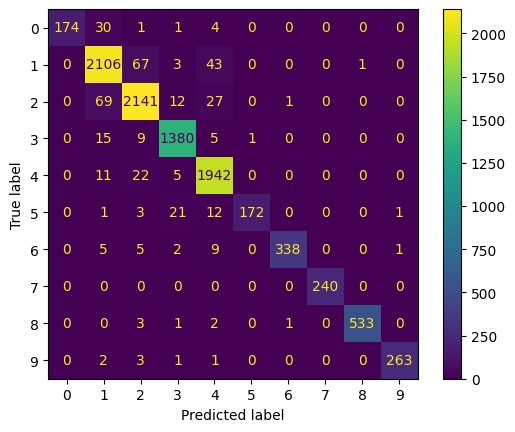

Accuracy: 0.9586171310629515
F1 Score: 0.958823617926966
Precision: 0.9591061545105048
Recall/Sensitivity/True Positive Rate: 0.9586171310629515
False Positive Rate: [0.         0.         0.         ... 0.87995643 0.87995643 1.        ]
Area under ROC curve: 0.996475515305175
Confusion Matrix:
 [[ 174   30    1    1    4    0    0    0    0    0]
 [   0 2106   67    3   43    0    0    0    1    0]
 [   0   69 2141   12   27    0    1    0    0    0]
 [   0   15    9 1380    5    1    0    0    0    0]
 [   0   11   22    5 1942    0    0    0    0    0]
 [   0    1    3   21   12  172    0    0    0    1]
 [   0    5    5    2    9    0  338    0    0    1]
 [   0    0    0    0    0    0    0  240    0    0]
 [   0    0    3    1    2    0    1    0  533    0]
 [   0    2    3    1    1    0    0    0    0  263]]


In [106]:
# testing set (normalized)
perceptron_clf_calibrated.fit(x_train_norm, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_train_norm, y_train)

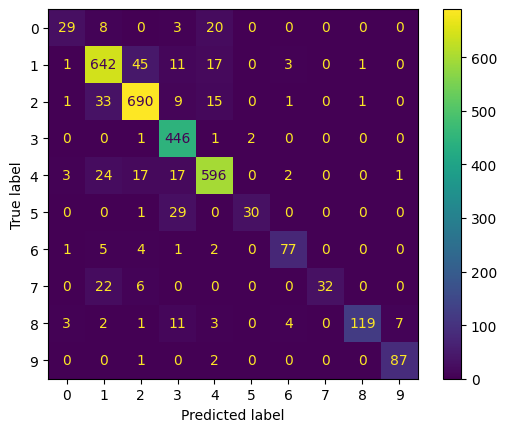

Accuracy: 0.8893203883495145
F1 Score: 0.8927535137086572
Precision: 0.8918240668164629
Recall/Sensitivity/True Positive Rate: 0.8893203883495145
False Positive Rate: [0.         0.         0.         ... 0.92477526 0.92477526 1.        ]
Area under ROC curve: 0.9804998182548255
Confusion Matrix:
 [[ 29   8   0   3  20   0   0   0   0   0]
 [  1 642  45  11  17   0   3   0   1   0]
 [  1  33 690   9  15   0   1   0   1   0]
 [  0   0   1 446   1   2   0   0   0   0]
 [  3  24  17  17 596   0   2   0   0   1]
 [  0   0   1  29   0  30   0   0   0   0]
 [  1   5   4   1   2   0  77   0   0   0]
 [  0  22   6   0   0   0   0  32   0   0]
 [  3   2   1  11   3   0   4   0 119   7]
 [  0   0   1   0   2   0   0   0   0  87]]


In [126]:
# testing set (normalized)
perceptron_clf_calibrated.fit(x_train_norm, y_train.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_test_norm, y_test)

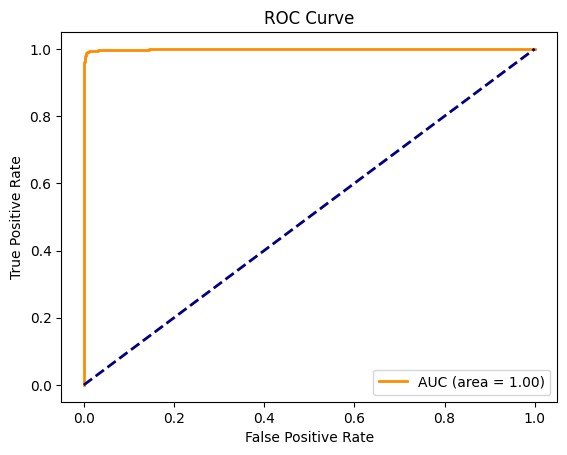

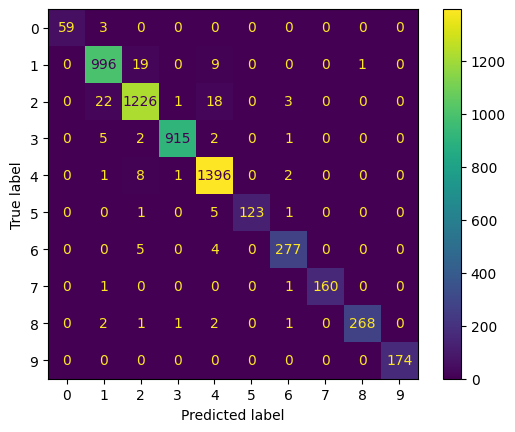

Accuracy: 0.9784852195207276
F1 Score: 0.9784857105715234
Precision: 0.9786026942438196
Recall/Sensitivity/True Positive Rate: 0.9784852195207276
False Positive Rate: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.94352127e-05
 1.94352127e-05 3.88704254e-05 3.88704254e-05 5.83056382e-05
 5.83056382e-05 7.77408509e-05 7.77408509e-05 9.71760636e-05
 9.71760636e-05 1.16611276e-04 1.16611276e-04 1.36046489e-04
 1.36046489e-04 1.55481702e-04 1.55481702e-04 1.74916914e-04
 1.74916914e-04 1.94352127e-04 1.94352127e-04 2.13787340e-04
 2.13787340e-04 2.33222553e-04 2.33222553e-04 2.52657765e-04
 2.52657765e-04 2.72092978e-04 2.72092978e-04 2.91528191e-04
 2.91528191e-04 3.10963403e-04 3.10963403e-04 3.30398616e-04
 3.30398616e-04 3.49833829e-04 3.49833829e-04 3.69269042e-04
 3.69269042e-04 3.88704254e-04 3.88704254e-04 4.08139467e-04
 4.08139467e-04 4.27574680e-04 4.27574680e-04 4.47009893e-04
 4.47009893e-04 4.66445105e-04 4.66445105e-04 4.85880318e-04
 4.85880318e-04 5.05315531e-04 5.0531553

In [127]:
# training set (normalized no outliers)
perceptron_clf_calibrated.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_train_no_outliers_norm, y_train_filtered_outlier_norm)

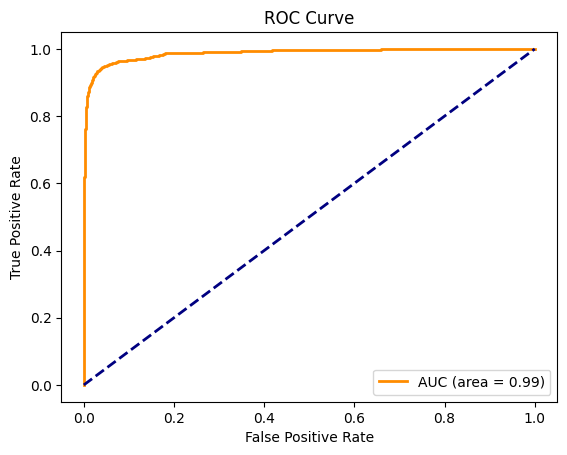

Accuracy: 0.8875479978058146
F1 Score: 0.8937897860050769
Precision: 0.8900191622397492
Recall/Sensitivity/True Positive Rate: 0.8875479978058146
False Positive Rate: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.09495947e-05
 6.09495947e-05 1.21899189e-04 1.21899189e-04 1.82848784e-04
 1.82848784e-04 2.43798379e-04 2.43798379e-04 3.04747973e-04
 3.04747973e-04 3.65697568e-04 3.65697568e-04 4.26647163e-04
 4.26647163e-04 4.87596757e-04 4.87596757e-04 5.48546352e-04
 5.48546352e-04 6.09495947e-04 6.09495947e-04 6.70445542e-04
 6.70445542e-04 7.31395136e-04 7.31395136e-04 7.92344731e-04
 7.92344731e-04 8.53294326e-04 8.53294326e-04 9.14243920e-04
 9.14243920e-04 9.75193515e-04 9.75193515e-04 1.03614311e-03
 1.03614311e-03 1.09709270e-03 1.09709270e-03 1.15804230e-03
 1.15804230e-03 1.21899189e-03 1.21899189e-03 1.27994149e-03
 1.27994149e-03 1.34089108e-03 1.34089108e-03 1.40184068e-03
 1.40184068e-03 1.52373987e-03 1.52373987e-03 1.58468946e-03
 1.58468946e-03 1.64563906e-03 1.6456390

In [128]:
# testing set (normalized no outliers)
perceptron_clf_calibrated.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
get_metrics(perceptron_clf_calibrated, x_test_no_outliers_norm, y_test_filtered_outlier_norm)

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

Cross-validation accuracy scores: [0.91744066 0.94014448 0.92672859 0.92363261 0.93085655 0.9370485
 0.94014448 0.92672859 0.93085655 0.93188854]
Mean accuracy: 0.930546955624355
Accuracy standard deviation: 0.0069081807930565986


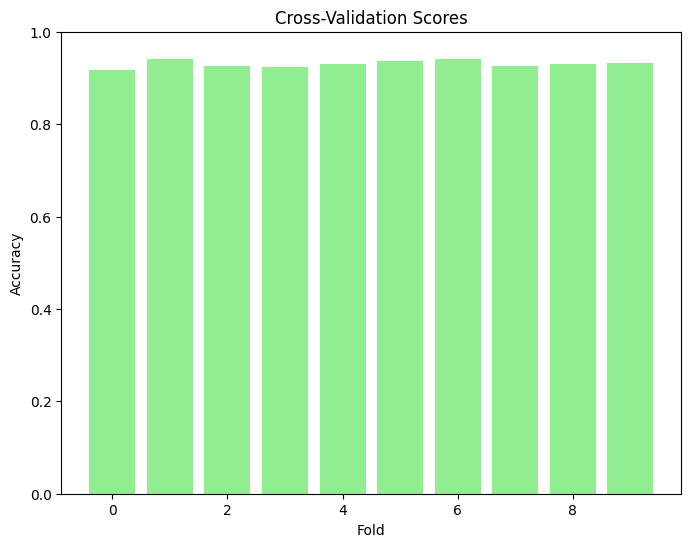

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

Overall Precision: 0.9517535374757005
Overall Recall: 0.9011540260901961
Overall F1 Score: 0.9241358680496938


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

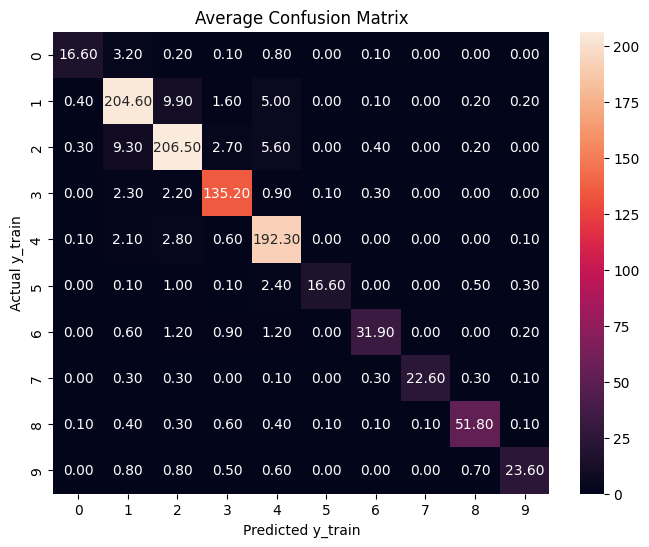

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

Overall ROC-AUC: 0.9921788000424163


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1183: DataCon

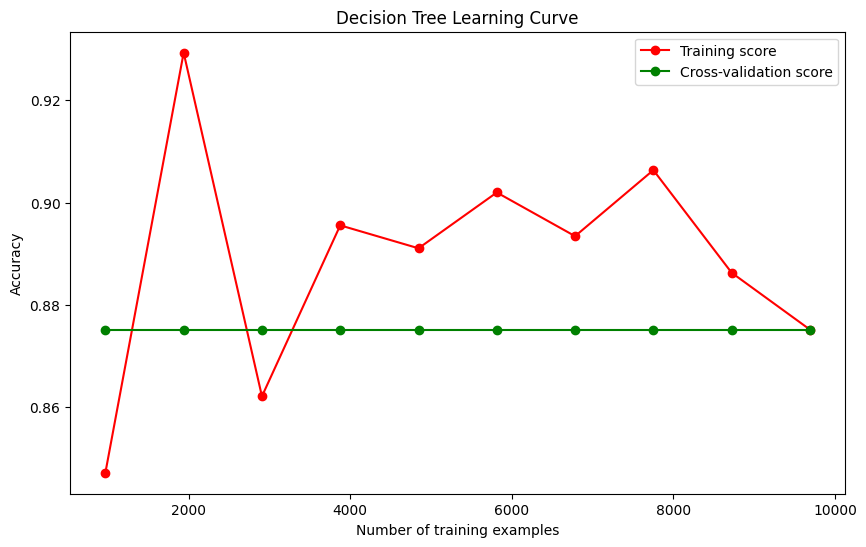

Average Training Score: 0.8888216858975696
Average Cross-Validation Score: 0.8751289989680082


In [53]:
# training set with 10-fold cross-valiation
get_cross_val_metrics(perceptron_clf_calibrated, x_train, y_train.to_numpy().ravel())
plot_learning_curve(perceptron_clf_calibrated, x_train, y_train.to_numpy().ravel())

In [18]:
from sklearn.neural_network import MLPClassifier

# baseline with default values for the hyperparameters (excl. solver, using gradient descent as done in the lectures)
mlp_clf = MLPClassifier(
    random_state=42, # save random state for reproducible results
    solver="sgd", # use (stochastic) gradient descent
    activation="relu", # activation function
    hidden_layer_sizes=(100,), # size for each hidden layer
    learning_rate_init=0.001, # initial learning rate
    max_iter=200, # no. of epochs
    momentum=0.9
)

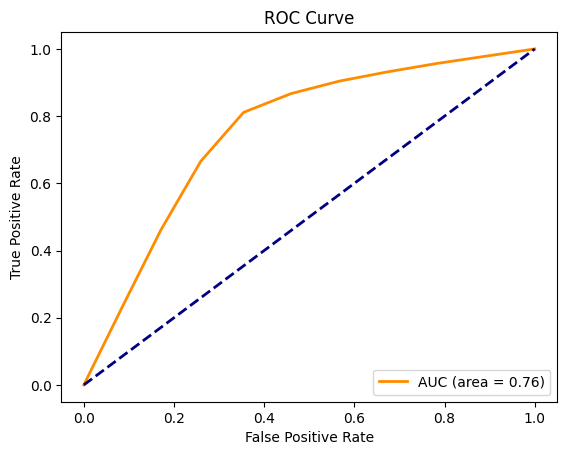

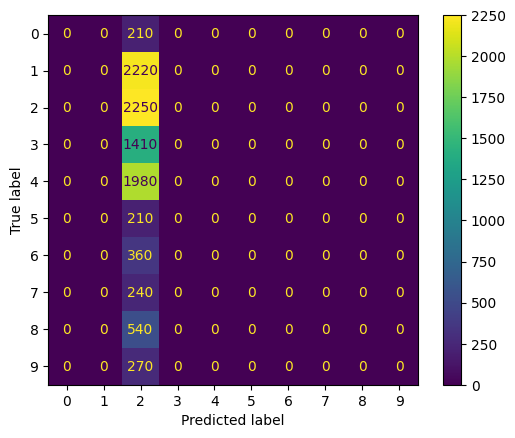

Accuracy: 0.23219814241486067
F1 Score: 0.37688442211055273
Precision: 0.8217178349260513
Recall/Sensitivity/True Positive Rate: 0.23219814241486067
Area under ROC curve: 0.5
Confusion Matrix:
 [[   0    0  210    0    0    0    0    0    0    0]
 [   0    0 2220    0    0    0    0    0    0    0]
 [   0    0 2250    0    0    0    0    0    0    0]
 [   0    0 1410    0    0    0    0    0    0    0]
 [   0    0 1980    0    0    0    0    0    0    0]
 [   0    0  210    0    0    0    0    0    0    0]
 [   0    0  360    0    0    0    0    0    0    0]
 [   0    0  240    0    0    0    0    0    0    0]
 [   0    0  540    0    0    0    0    0    0    0]
 [   0    0  270    0    0    0    0    0    0    0]]


In [153]:
# testing default MLPClassifier on training set

mlp_clf.fit(x_train, y_train.to_numpy().ravel())
get_metrics(mlp_clf, x_train, y_train)

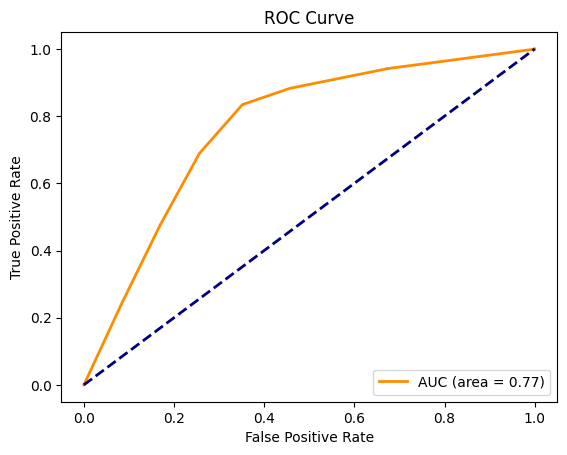

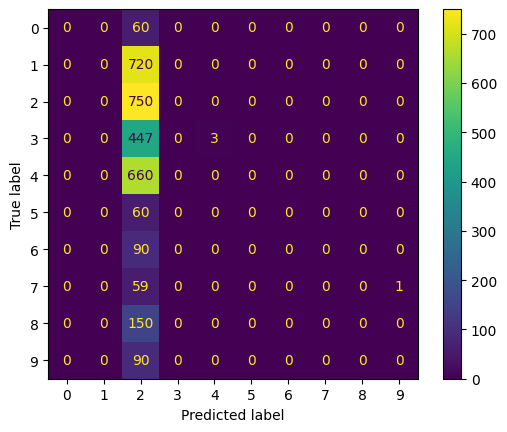

Accuracy: 0.24271844660194175
F1 Score: 0.39052613462648184
Precision: 0.5735517117706649
Recall/Sensitivity/True Positive Rate: 0.24271844660194175
Area under ROC curve: 0.49969625403087203
Confusion Matrix:
 [[  0   0  60   0   0   0   0   0   0   0]
 [  0   0 720   0   0   0   0   0   0   0]
 [  0   0 750   0   0   0   0   0   0   0]
 [  0   0 447   0   3   0   0   0   0   0]
 [  0   0 660   0   0   0   0   0   0   0]
 [  0   0  60   0   0   0   0   0   0   0]
 [  0   0  90   0   0   0   0   0   0   0]
 [  0   0  59   0   0   0   0   0   0   1]
 [  0   0 150   0   0   0   0   0   0   0]
 [  0   0  90   0   0   0   0   0   0   0]]


In [154]:
# testing default MLPClassifier on validation set

mlp_clf.fit(x_train, y_train.to_numpy().ravel())
get_metrics(mlp_clf, x_test, y_test)

SGD did not converge.


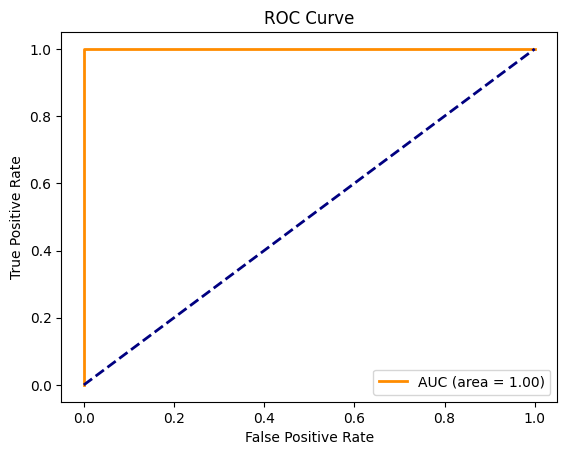

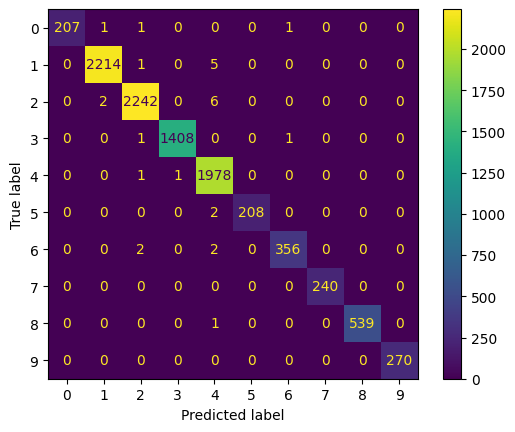

Accuracy: 0.997110423116615
F1 Score: 0.9971103588337135
Precision: 0.9971198200707179
Recall/Sensitivity/True Positive Rate: 0.997110423116615
Area under ROC curve: 0.999941422342321
Confusion Matrix:
 [[ 207    1    1    0    0    0    1    0    0    0]
 [   0 2214    1    0    5    0    0    0    0    0]
 [   0    2 2242    0    6    0    0    0    0    0]
 [   0    0    1 1408    0    0    1    0    0    0]
 [   0    0    1    1 1978    0    0    0    0    0]
 [   0    0    0    0    2  208    0    0    0    0]
 [   0    0    2    0    2    0  356    0    0    0]
 [   0    0    0    0    0    0    0  240    0    0]
 [   0    0    0    0    1    0    0    0  539    0]
 [   0    0    0    0    0    0    0    0    0  270]]


In [155]:
# STOPPED RUNNING HERE

# testing default MLPClassifier on normalized training set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_train_norm, y_train)

# return to normal warning behaviour
warnings.resetwarnings()

SGD did not converge.


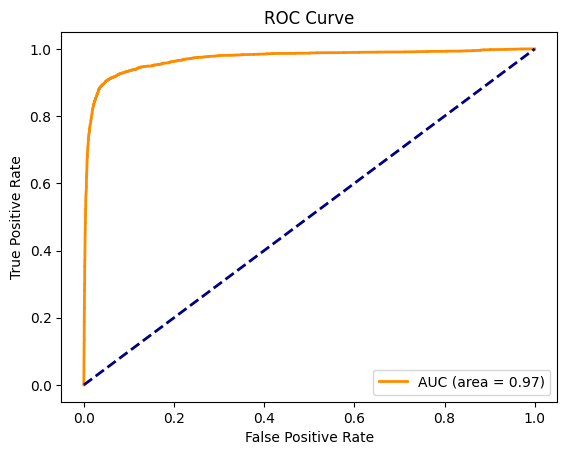

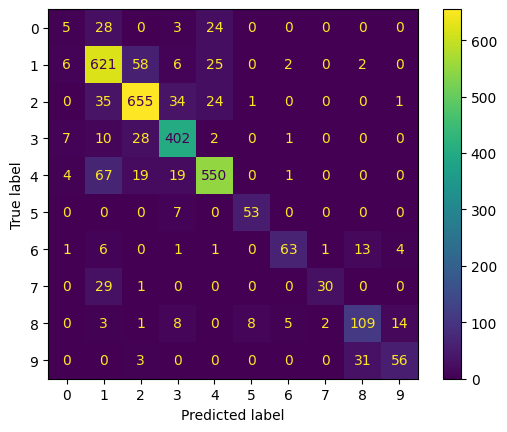

Accuracy: 0.8233009708737864
F1 Score: 0.8287491322905155
Precision: 0.8183872792708318
Recall/Sensitivity/True Positive Rate: 0.8233009708737864
Area under ROC curve: 0.9618727891806784
Confusion Matrix:
 [[  5  28   0   3  24   0   0   0   0   0]
 [  6 621  58   6  25   0   2   0   2   0]
 [  0  35 655  34  24   1   0   0   0   1]
 [  7  10  28 402   2   0   1   0   0   0]
 [  4  67  19  19 550   0   1   0   0   0]
 [  0   0   0   7   0  53   0   0   0   0]
 [  1   6   0   1   1   0  63   1  13   4]
 [  0  29   1   0   0   0   0  30   0   0]
 [  0   3   1   8   0   8   5   2 109  14]
 [  0   0   3   0   0   0   0   0  31  56]]


In [156]:
# testing default MLPClassifier on normalized testing set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_test_norm, y_test)

# return to normal warning behaviour
warnings.resetwarnings()

SGD did not converge.


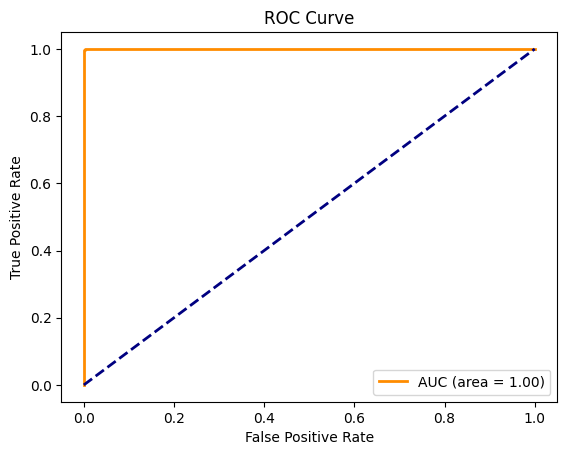

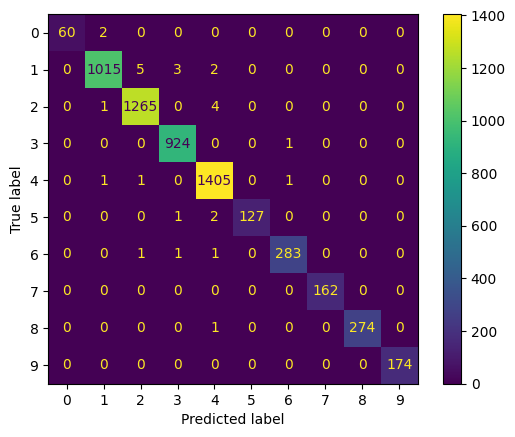

Accuracy: 0.9951023263949624
F1 Score: 0.9951079988379075
Precision: 0.9951113231997473
Recall/Sensitivity/True Positive Rate: 0.9951023263949624
Area under ROC curve: 0.9998756619643709
Confusion Matrix:
 [[  60    2    0    0    0    0    0    0    0    0]
 [   0 1015    5    3    2    0    0    0    0    0]
 [   0    1 1265    0    4    0    0    0    0    0]
 [   0    0    0  924    0    0    1    0    0    0]
 [   0    1    1    0 1405    0    1    0    0    0]
 [   0    0    0    1    2  127    0    0    0    0]
 [   0    0    1    1    1    0  283    0    0    0]
 [   0    0    0    0    0    0    0  162    0    0]
 [   0    0    0    0    1    0    0    0  274    0]
 [   0    0    0    0    0    0    0    0    0  174]]


In [136]:
# testing default MLPClassifier on normalized and outlier mined training set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)

# return to normal warning behaviour
warnings.resetwarnings()

SGD did not converge.


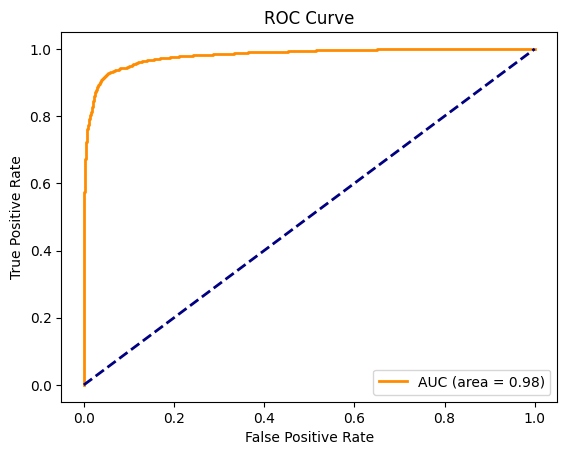

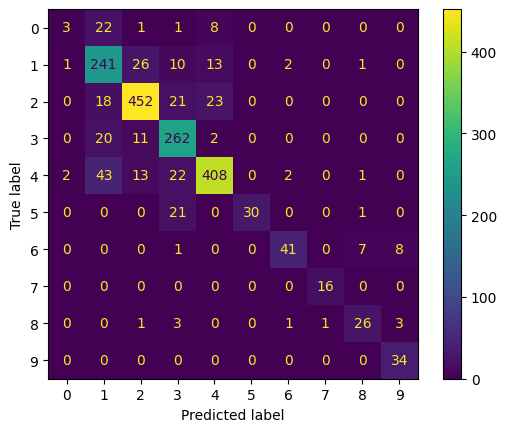

Accuracy: 0.829950630828305
F1 Score: 0.8345902367027265
Precision: 0.8344361026001998
Recall/Sensitivity/True Positive Rate: 0.829950630828305
Area under ROC curve: 0.9733994389109427
Confusion Matrix:
 [[  3  22   1   1   8   0   0   0   0   0]
 [  1 241  26  10  13   0   2   0   1   0]
 [  0  18 452  21  23   0   0   0   0   0]
 [  0  20  11 262   2   0   0   0   0   0]
 [  2  43  13  22 408   0   2   0   1   0]
 [  0   0   0  21   0  30   0   0   1   0]
 [  0   0   0   1   0   0  41   0   7   8]
 [  0   0   0   0   0   0   0  16   0   0]
 [  0   0   1   3   0   0   1   1  26   3]
 [  0   0   0   0   0   0   0   0   0  34]]


In [137]:
# testing default MLPClassifier on normalized and outlier mined testing set

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

try:
    mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
except Warning:
    print("SGD did not converge.")
else:
    print("SGD converged.")
get_metrics(mlp_clf, x_test_no_outliers_norm, y_test_filtered_outlier_norm)

# return to normal warning behaviour
warnings.resetwarnings()

Incresing the size of a layer did not have a significant increase in performance past 100 and had no significant effect on overfitting

In [141]:
# experimenting with the size of one hidden layer

import warnings

# handle warnings as errors (for ConverganceWarning)
warnings.filterwarnings("error")

# initialize dataframes for results
train_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
# loop over different variations of the model
i = 0
for size in [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,)]:
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation="relu",
        hidden_layer_sizes=size,
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9
    )
    # train data and specify whether gradient descent converged or not
    try:
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
    except Warning:
        print(size, "  -   SGD did not converge.")
    else:
        print(size, "  -   SGD converged!")
    train_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_train_norm, y_train)
    test_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

# display results
print("train set")
display(train_set)
print("test set")
display(test_set)

# return to normal warning behaviour
warnings.resetwarnings()

(1,)   -   SGD did not converge.
(2,)   -   SGD did not converge.
(3,)   -   SGD did not converge.
(4,)   -   SGD did not converge.
(5,)   -   SGD did not converge.
(6,)   -   SGD did not converge.
(7,)   -   SGD did not converge.
(8,)   -   SGD did not converge.
(9,)   -   SGD did not converge.
(10,)   -   SGD did not converge.
(11,)   -   SGD did not converge.
(12,)   -   SGD did not converge.
train set


size  accuracy        f1  precision    recall       roc
0    (1,)  0.483798  0.637856   0.733323  0.483798  0.865169
1    (2,)  0.696388  0.783717   0.740060  0.696388  0.941852
2    (3,)  0.855521  0.886455   0.878088  0.855521  0.986914
3    (4,)  0.881527  0.906662   0.889977  0.881527  0.990715
4    (5,)  0.905057  0.921259   0.911176  0.905057  0.995373
5    (6,)  0.941383  0.943626   0.939801  0.941383  0.997158
6    (7,)  0.956244  0.962881   0.954841  0.956244  0.998596
7    (8,)  0.973065  0.973351   0.973099  0.973065  0.998868
8    (9,)  0.978741  0.978772   0.978731  0.978741  0.999186
9   (10,)  0.982869  0.982879   0.982910  0.982869  0.999495
10  (11,)  0.980495  0.980620   0.980626  0.980495  0.999311
11  (12,)  0.981734  0.981826   0.981877  0.981734  0.999426

test set


size  accuracy        f1  precision    recall       roc
0    (1,)  0.477670  0.625695   0.728238  0.477670  0.842216
1    (2,)  0.664078  0.744109   0.774467  0.664078  0.908133
2    (3,)  0.807120  0.836758   0.843734  0.807120  0.952550
3    (4,)  0.791909  0.816204   0.773248  0.791909  0.951564
4    (5,)  0.820388  0.839191   0.803389  0.820388  0.962237
5    (6,)  0.831068  0.840361   0.822008  0.831068  0.961844
6    (7,)  0.849838  0.859005   0.836554  0.849838  0.965718
7    (8,)  0.847573  0.853549   0.845132  0.847573  0.964544
8    (9,)  0.861165  0.862913   0.862493  0.861165  0.968730
9   (10,)  0.865696  0.868991   0.865676  0.865696  0.967234
10  (11,)  0.858900  0.861926   0.859592  0.858900  0.964137
11  (12,)  0.862460  0.867387   0.862295  0.862460  0.965919

As the number of nodes in a layer increases, the accuracy increases. However, as shown by the large difference between the training and testing sets n >= 4, too many nodes leads to overfitting

In [144]:
# experimenting with epochs and different sizes for a hidden layer

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["epochs", "size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["epochs", "size", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for epochs in [150, 300, 450]:
    for size in [(2,), (6,), (12,)]:
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=size,
            learning_rate_init=0.001,
            max_iter=epochs,
            momentum=0.9
        )
        try:
            mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        except Warning:
            print(epochs, size, "  -   SGD did not converge.")
        else:
            print(epochs, size, "  -   SGD converged!.")
        train_set.loc[i] = [str(epochs), str(size)] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [str(epochs), str(size)] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

150 (2,)   -   SGD did not converge.
150 (6,)   -   SGD did not converge.
150 (12,)   -   SGD did not converge.
300 (2,)   -   SGD did not converge.
300 (6,)   -   SGD did not converge.
300 (12,)   -   SGD did not converge.
450 (2,)   -   SGD did not converge.
450 (6,)   -   SGD did not converge.
450 (12,)   -   SGD did not converge.
train set


epochs   size  accuracy        f1  precision    recall       roc
0    150   (2,)  0.694118  0.779689   0.665350  0.694118  0.938979
1    150   (6,)  0.915686  0.923957   0.913971  0.915686  0.995838
2    150  (12,)  0.973271  0.973394   0.973448  0.973271  0.998935
3    300   (2,)  0.702374  0.788005   0.793205  0.702374  0.943806
4    300   (6,)  0.967389  0.967556   0.967311  0.967389  0.998428
5    300  (12,)  0.989370  0.989369   0.989440  0.989370  0.999726
6    450   (2,)  0.721569  0.794628   0.816008  0.721569  0.945605
7    450   (6,)  0.978225  0.978280   0.978214  0.978225  0.999167
8    450  (12,)  0.995666  0.995665   0.995675  0.995666  0.999877

test set


epochs   size  accuracy        f1  precision    recall       roc
0    150   (2,)  0.660518  0.738756   0.774232  0.660518  0.908109
1    150   (6,)  0.823301  0.840500   0.814766  0.823301  0.961100
2    150  (12,)  0.862783  0.867672   0.863384  0.862783  0.965998
3    300   (2,)  0.666343  0.746735   0.747208  0.666343  0.907589
4    300   (6,)  0.844660  0.850638   0.838800  0.844660  0.964678
5    300  (12,)  0.867638  0.871385   0.867565  0.867638  0.967273
6    450   (2,)  0.669579  0.741959   0.749294  0.669579  0.906726
7    450   (6,)  0.852751  0.857375   0.848087  0.852751  0.966685
8    450  (12,)  0.862460  0.866304   0.860648  0.862460  0.966864

As shown above, increasing the number of epochs increases accuracy, but once again, a very large number leads to overfitting.
Despite increasing the number of epochs, optimization still does not converge, indicating the need for regularization and a different/varying learning rate

In [146]:
# experimenting with different learning rates and alpha values

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["lr", "alpha", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["lr", "alpha", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for lr in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
# for lr in [0.005, 0.01, 0.05, 0.1, 0.5]:
    for alpha in (10.0**-np.arange(1,7)):
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=(3,),
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=200,
            momentum=0.9
        )
        try:
            mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        except Warning:
            print(lr, alpha, "  -   SGD did not converge.")
        else:
            print(lr, alpha, "  -   SGD converged!.")
        train_set.loc[i] = [lr, alpha] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [lr, alpha] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)  
print("test set")
display(test_set)

warnings.resetwarnings()

0.0001 0.1   -   SGD did not converge.
0.0001 0.01   -   SGD did not converge.
0.0001 0.001   -   SGD did not converge.
0.0001 0.0001   -   SGD did not converge.
0.0001 1e-05   -   SGD did not converge.
0.0001 1e-06   -   SGD did not converge.
0.0005 0.1   -   SGD did not converge.
0.0005 0.01   -   SGD did not converge.
0.0005 0.001   -   SGD did not converge.
0.0005 0.0001   -   SGD did not converge.
0.0005 1e-05   -   SGD did not converge.
0.0005 1e-06   -   SGD did not converge.
0.001 0.1   -   SGD did not converge.
0.001 0.01   -   SGD did not converge.
0.001 0.001   -   SGD did not converge.
0.001 0.0001   -   SGD did not converge.
0.001 1e-05   -   SGD did not converge.
0.001 1e-06   -   SGD did not converge.
0.005 0.1   -   SGD converged!.
0.005 0.01   -   SGD converged!.
0.005 0.001   -   SGD converged!.
0.005 0.0001   -   SGD converged!.
0.005 1e-05   -   SGD converged!.
0.005 1e-06   -   SGD converged!.
0.01 0.1   -   SGD converged!.
0.01 0.01   -   SGD did not converge.
0.0

lr     alpha  accuracy        f1  precision    recall       roc
0   0.0001  0.100000  0.605779  0.652504   0.673437  0.605779  0.903075
1   0.0001  0.010000  0.605882  0.652590   0.673574  0.605882  0.903142
2   0.0001  0.001000  0.605986  0.652714   0.673647  0.605986  0.903148
3   0.0001  0.000100  0.606089  0.652839   0.673701  0.606089  0.903154
4   0.0001  0.000010  0.606089  0.652839   0.673701  0.606089  0.903154
5   0.0001  0.000001  0.606089  0.652839   0.673701  0.606089  0.903154
6   0.0005  0.100000  0.817337  0.863626   0.839321  0.817337  0.982209
7   0.0005  0.010000  0.817234  0.863086   0.839554  0.817234  0.982274
8   0.0005  0.001000  0.817647  0.863415   0.841063  0.817647  0.982253
9   0.0005  0.000100  0.817750  0.863570   0.841188  0.817750  0.982263
10  0.0005  0.000010  0.817647  0.863604   0.840443  0.817647  0.982264
11  0.0005  0.000001  0.817647  0.863604   0.840443  0.817647  0.982264
12  0.0010  0.100000  0.854076  0.885119   0.876175  0.854076  0.986791
13  0.0010  0.010000  0.855315  0.886300   0.877759  0.855315  0.986943
14  0.0010  0.001000  0.855212  0.886172   0.877723  0.855212  0.986956
15  0.0010  0.000100  0.855521  0.886455   0.878088  0.855521  0.986914
16  0.0010  0.000010  0.855315  0.886219   0.877933  0.855315  0.986903
17  0.0010  0.000001  0.855315  0.886219   0.877933  0.855315  0.986903
18  0.0050  0.100000  0.864499  0.890691   0.885192  0.864499  0.991426
19  0.0050  0.010000  0.867802  0.894119   0.851409  0.867802  0.991494
20  0.0050  0.001000  0.867595  0.894554   0.873533  0.867595  0.991613
21  0.0050  0.000100  0.868627  0.894773   0.857389  0.868627  0.991472
22  0.0050  0.000010  0.869453  0.896028   0.875836  0.869453  0.991549
23  0.0050  0.000001  0.869556  0.895993   0.876102  0.869556  0.991525
24  0.0100  0.100000  0.881734  0.894567   0.872604  0.881734  0.992899
25  0.0100  0.010000  0.902580  0.911072   0.908817  0.902580  0.994366
26  0.0100  0.001000  0.885862  0.893702   0.879633  0.885862  0.993560
27  0.0100  0.000100  0.904128  0.913126   0.895669  0.904128  0.994370
28  0.0100  0.000010  0.901754  0.909605   0.896950  0.901754  0.994243
29  0.0100  0.000001  0.901754  0.909605   0.896950  0.901754  0.994243
30  0.0500  0.100000  0.873994  0.894844   0.881571  0.873994  0.989356
31  0.0500  0.010000  0.860784  0.877695   0.862904  0.860784  0.988119
32  0.0500  0.001000  0.871001  0.892845   0.866156  0.871001  0.988058
33  0.0500  0.000100  0.837358  0.862138   0.869872  0.837358  0.985315
34  0.0500  0.000010  0.839112  0.858807   0.842832  0.839112  0.986714
35  0.0500  0.000001  0.853767  0.871458   0.871291  0.853767  0.987034
36  0.1000  0.100000  0.159236  0.228934   0.684733  0.159236  0.478163
37  0.1000  0.010000  0.251909  0.345697   0.570880  0.251909  0.526656
38  0.1000  0.001000  0.153767  0.194288   0.401373  0.153767  0.525182
39  0.1000  0.000100  0.152116  0.216093   0.776867  0.152116  0.509311
40  0.1000  0.000010  0.140557  0.184834   0.259798  0.140557  0.457058
41  0.1000  0.000001  0.234365  0.333984   0.530995  0.234365  0.542995

test set


lr     alpha  accuracy        f1  precision    recall       roc
0   0.0001  0.100000  0.581230  0.623031   0.641931  0.581230  0.850509
1   0.0001  0.010000  0.581553  0.623351   0.642253  0.581553  0.850431
2   0.0001  0.001000  0.581877  0.623643   0.642629  0.581877  0.850437
3   0.0001  0.000100  0.581877  0.623671   0.642575  0.581877  0.850424
4   0.0001  0.000010  0.581877  0.623671   0.642575  0.581877  0.850424
5   0.0001  0.000001  0.581877  0.623671   0.642575  0.581877  0.850424
6   0.0005  0.100000  0.791262  0.834319   0.803856  0.791262  0.948818
7   0.0005  0.010000  0.791909  0.834406   0.808311  0.791909  0.948683
8   0.0005  0.001000  0.793528  0.836099   0.809885  0.793528  0.948725
9   0.0005  0.000100  0.794175  0.836785   0.810438  0.794175  0.948712
10  0.0005  0.000010  0.793204  0.835695   0.809824  0.793204  0.948751
11  0.0005  0.000001  0.793204  0.835695   0.809824  0.793204  0.948751
12  0.0010  0.100000  0.809385  0.839383   0.845307  0.809385  0.953005
13  0.0010  0.010000  0.808414  0.838163   0.844904  0.808414  0.952849
14  0.0010  0.001000  0.808414  0.838173   0.844882  0.808414  0.952785
15  0.0010  0.000100  0.807120  0.836758   0.843734  0.807120  0.952550
16  0.0010  0.000010  0.807767  0.837415   0.844350  0.807767  0.952545
17  0.0010  0.000001  0.807767  0.837415   0.844350  0.807767  0.952544
18  0.0050  0.100000  0.819741  0.844618   0.829558  0.819741  0.956259
19  0.0050  0.010000  0.818447  0.841736   0.809592  0.818447  0.954881
20  0.0050  0.001000  0.822654  0.846415   0.852226  0.822654  0.957058
21  0.0050  0.000100  0.818447  0.842208   0.799520  0.818447  0.955242
22  0.0050  0.000010  0.821683  0.845017   0.851606  0.821683  0.956514
23  0.0050  0.000001  0.821683  0.845209   0.851376  0.821683  0.956517
24  0.0100  0.100000  0.807767  0.822196   0.787652  0.807767  0.959294
25  0.0100  0.010000  0.784142  0.795183   0.780479  0.784142  0.953261
26  0.0100  0.001000  0.802265  0.814020   0.789431  0.802265  0.956849
27  0.0100  0.000100  0.783819  0.793861   0.780839  0.783819  0.954616
28  0.0100  0.000010  0.788350  0.799322   0.779585  0.788350  0.954895
29  0.0100  0.000001  0.788350  0.799322   0.779585  0.788350  0.954894
30  0.0500  0.100000  0.804854  0.826154   0.801977  0.804854  0.958106
31  0.0500  0.010000  0.801294  0.821311   0.796504  0.801294  0.954087
32  0.0500  0.001000  0.808738  0.833130   0.792837  0.808738  0.955840
33  0.0500  0.000100  0.774110  0.799565   0.782802  0.774110  0.951489
34  0.0500  0.000010  0.747249  0.771994   0.750526  0.747249  0.949970
35  0.0500  0.000001  0.775728  0.794079   0.783270  0.775728  0.950354
36  0.1000  0.100000  0.180583  0.256378   0.685659  0.180583  0.485662
37  0.1000  0.010000  0.246602  0.333970   0.569369  0.246602  0.517657
38  0.1000  0.001000  0.168285  0.212348   0.642579  0.168285  0.535664
39  0.1000  0.000100  0.117799  0.160713   0.765730  0.117799  0.489558
40  0.1000  0.000010  0.181877  0.232762   0.273760  0.181877  0.479499
41  0.1000  0.000001  0.247573  0.349599   0.494831  0.247573  0.538266

A very low learning rate led to lower accuracies, indicating that there were not enough epochs to approach the minimum with such a low learning rate. A very high learning rate resulted in even lower accuracies, indicating that the algorithm overshot the minumum and was diverging. changing alpha (regularization strength had a minimal effect on the results)

In [103]:
# experimenting with constant and varying learning rates

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["learning rate", "size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["learning rate", "size", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for lr in ["constant", "adaptive", "invscaling"]:
    for size in [(2,), (3,), (4,), (5,), (6,)]:
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=size,
            learning_rate=lr,
            max_iter=200,
            momentum=0.9
        )
        # mlp_clf.fit(x, y_train_filtered_outlier_norm.to_numpy().ravel())
        # train_set.loc[i] = [lr, size] + get_metrics_array(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)
        try:
            mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        except Warning:
            print(str(lr) + ",", size, "  -   SGD did not converge.")
        else:
            print(str(lr) + ",", size, "  -   SGD converged!")
        train_set.loc[i] = [lr, size] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [lr, size] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

constant, (2,)   -   SGD did not converge.
constant, (3,)   -   SGD did not converge.
constant, (4,)   -   SGD did not converge.
constant, (5,)   -   SGD did not converge.
constant, (6,)   -   SGD did not converge.
adaptive, (2,)   -   SGD did not converge.
adaptive, (3,)   -   SGD did not converge.
adaptive, (4,)   -   SGD did not converge.
adaptive, (5,)   -   SGD did not converge.
adaptive, (6,)   -   SGD did not converge.
invscaling, (2,)   -   SGD did not converge.
invscaling, (3,)   -   SGD did not converge.
invscaling, (4,)   -   SGD converged!
invscaling, (5,)   -   SGD did not converge.
invscaling, (6,)   -   SGD did not converge.
train set


learning rate  size  accuracy        f1  precision    recall       roc
0       constant  (2,)  0.696388  0.783717   0.740060  0.696388  0.941852
1       constant  (3,)  0.855521  0.886455   0.878088  0.855521  0.986914
2       constant  (4,)  0.881527  0.906662   0.889977  0.881527  0.990715
3       constant  (5,)  0.905057  0.921259   0.911176  0.905057  0.995373
4       constant  (6,)  0.941383  0.943626   0.939801  0.941383  0.997158
5       adaptive  (2,)  0.696388  0.783717   0.740060  0.696388  0.941852
6       adaptive  (3,)  0.855521  0.886455   0.878088  0.855521  0.986914
7       adaptive  (4,)  0.881527  0.906662   0.889977  0.881527  0.990715
8       adaptive  (5,)  0.905057  0.921259   0.911176  0.905057  0.995373
9       adaptive  (6,)  0.941383  0.943626   0.939801  0.941383  0.997158
10    invscaling  (2,)  0.168627  0.189352   0.590709  0.168627  0.600645
11    invscaling  (3,)  0.046130  0.061681   0.768724  0.046130  0.688943
12    invscaling  (4,)  0.289577  0.380669   0.619252  0.289577  0.687946
13    invscaling  (5,)  0.338080  0.386426   0.582533  0.338080  0.716827
14    invscaling  (6,)  0.272033  0.322698   0.443392  0.272033  0.699475

test set


learning rate  size  accuracy        f1  precision    recall       roc
0       constant  (2,)  0.664078  0.744109   0.774467  0.664078  0.908133
1       constant  (3,)  0.807120  0.836758   0.843734  0.807120  0.952550
2       constant  (4,)  0.791909  0.816204   0.773248  0.791909  0.951564
3       constant  (5,)  0.820388  0.839191   0.803389  0.820388  0.962237
4       constant  (6,)  0.831068  0.840361   0.822008  0.831068  0.961844
5       adaptive  (2,)  0.664078  0.744109   0.774467  0.664078  0.908133
6       adaptive  (3,)  0.807120  0.836758   0.843734  0.807120  0.952550
7       adaptive  (4,)  0.791909  0.816204   0.773248  0.791909  0.951564
8       adaptive  (5,)  0.820388  0.839191   0.803389  0.820388  0.962237
9       adaptive  (6,)  0.831068  0.840361   0.822008  0.831068  0.961844
10    invscaling  (2,)  0.195793  0.222377   0.557992  0.195793  0.560030
11    invscaling  (3,)  0.049838  0.073082   0.629966  0.049838  0.642651
12    invscaling  (4,)  0.259871  0.365457   0.542802  0.259871  0.618292
13    invscaling  (5,)  0.319741  0.370355   0.552308  0.319741  0.658119
14    invscaling  (6,)  0.225243  0.271017   0.422000  0.225243  0.653519

In [37]:
# experimenting with different numbers of layers and sizes of said layers

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["size", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for size in [(3,), (3, 3), (3, 3, 3), (3, 3, 3, 3), (3, 3, 3, 3, 3), (10,), (10, 10), (10, 10, 10)]:
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation="relu",
        hidden_layer_sizes=size,
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9
    )
    try:
        mlp_clf.fit(x_train_no_outliers_norm, y_train_filtered_outlier_norm.to_numpy().ravel())
    except Warning:
        print(size, "  -   SGD did not converge.")
    else:
        print(size, "  -   SGD converged!")
    train_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_train_no_outliers_norm, y_train_filtered_outlier_norm)
    test_set.loc[i] = [size] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

(3,)   -   SGD did not converge.
(3, 3)   -   SGD did not converge.
(3, 3, 3)   -   SGD did not converge.
(3, 3, 3, 3)   -   SGD did not converge.
(3, 3, 3, 3, 3)   -   SGD did not converge.
(10,)   -   SGD did not converge.
(10, 10)   -   SGD did not converge.
(10, 10, 10)   -   SGD did not converge.
train set


size  accuracy        f1  precision    recall       roc
0             (3,)  0.829281  0.854433   0.882242  0.829281  0.986720
1           (3, 3)  0.779605  0.811059   0.876740  0.779605  0.971192
2        (3, 3, 3)  0.751618  0.818731   0.841892  0.751618  0.971241
3     (3, 3, 3, 3)  0.697569  0.767555   0.763827  0.697569  0.923282
4  (3, 3, 3, 3, 3)  0.790275  0.832895   0.815955  0.790275  0.978532
5            (10,)  0.982683  0.982721   0.982693  0.982683  0.999143
6         (10, 10)  0.976386  0.977019   0.976281  0.976386  0.999190
7     (10, 10, 10)  0.991079  0.991109   0.991077  0.991079  0.999653

test set


size  accuracy        f1  precision    recall       roc
0             (3,)  0.690615  0.711800   0.750775  0.690615  0.914863
1           (3, 3)  0.619417  0.649725   0.706607  0.619417  0.865531
2        (3, 3, 3)  0.631392  0.687643   0.709085  0.631392  0.885249
3     (3, 3, 3, 3)  0.585437  0.639569   0.651844  0.585437  0.799082
4  (3, 3, 3, 3, 3)  0.638835  0.668206   0.671026  0.638835  0.880971
5            (10,)  0.736893  0.742051   0.740564  0.736893  0.922085
6         (10, 10)  0.649191  0.645855   0.668513  0.649191  0.883250
7     (10, 10, 10)  0.694175  0.695782   0.695702  0.694175  0.895217

In [34]:
# experimenting with different activation functions

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["activation", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["activation", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for activation in ["identity", "logistic", "tanh", "relu"]:
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation=activation,
        hidden_layer_sizes=(3,),
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9
    )
    try:
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
    except Warning:
        print(activation, "  -   SGD did not converge.")
    else:
        print(activation, "  -   SGD converged!")
    train_set.loc[i] = [activation] + get_metrics_array(mlp_clf, x_train_norm, y_train)
    test_set.loc[i] = [activation] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

SGD did not converge.
SGD did not converge.
SGD did not converge.
SGD did not converge.
train set


activation  accuracy        f1  precision    recall       roc
0   identity  0.929618  0.930252   0.929511  0.929618  0.994216
1   logistic  0.782353  0.826156   0.841971  0.782353  0.963756
2       tanh  0.865015  0.886961   0.877096  0.865015  0.980138
3       relu  0.855521  0.886455   0.878088  0.855521  0.986914

test set


activation  accuracy        f1  precision    recall       roc
0   identity  0.826537  0.830000   0.824536  0.826537  0.958697
1   logistic  0.713269  0.749560   0.773068  0.713269  0.924221
2       tanh  0.798382  0.816293   0.813373  0.798382  0.951674
3       relu  0.807120  0.836758   0.843734  0.807120  0.952550

relu has the smallest difference between the traing and testing sets, indication it leads to less overfitting, while at the sime time not having the lowest accuracy

In [147]:
# experimenting with different momentum values and methods (nesterov/standard)

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["nesterov", "momentum", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["nesterov", "momentum", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for nesterovs in [False, True]:
    for momentum in [0.2, 0.4, 0.5, 0.6, 0.8, 0.9]:
        mlp_clf = MLPClassifier(
            random_state=42,
            solver="sgd",
            activation="relu",
            hidden_layer_sizes=(3,),
            learning_rate_init=0.001,
            max_iter=200,
            momentum=momentum,
            nesterovs_momentum=nesterovs
        )
        try:
            mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
        except Warning:
            print(nesterovs, momentum, "  -   SGD did not converge.")
        else:
            print(nesterovs, momentum, "  -   SGD converged!")
        train_set.loc[i] = [nesterovs, momentum] + get_metrics_array(mlp_clf, x_train_norm, y_train)
        test_set.loc[i] = [nesterovs, momentum] + get_metrics_array(mlp_clf, x_test_norm, y_test)
        i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

False 0.2   -   SGD did not converge.
False 0.4   -   SGD did not converge.
False 0.5   -   SGD did not converge.
False 0.6   -   SGD did not converge.
False 0.8   -   SGD did not converge.
False 0.9   -   SGD did not converge.
True 0.2   -   SGD did not converge.
True 0.4   -   SGD did not converge.
True 0.5   -   SGD did not converge.
True 0.6   -   SGD did not converge.
True 0.8   -   SGD did not converge.
True 0.9   -   SGD did not converge.
train set


nesterov  momentum  accuracy        f1  precision    recall       roc
0      False       0.2  0.637461  0.682191   0.710667  0.637461  0.922744
1      False       0.4  0.694530  0.742990   0.770052  0.694530  0.947471
2      False       0.5  0.704025  0.762835   0.785754  0.704025  0.958648
3      False       0.6  0.729515  0.796103   0.815385  0.729515  0.968920
4      False       0.8  0.816512  0.862802   0.838317  0.816512  0.982412
5      False       0.9  0.853044  0.884348   0.874783  0.853044  0.986992
6       True       0.2  0.637874  0.682570   0.711237  0.637874  0.922757
7       True       0.4  0.694221  0.742661   0.769599  0.694221  0.947710
8       True       0.5  0.704541  0.763464   0.786185  0.704541  0.958964
9       True       0.6  0.731063  0.797878   0.816490  0.731063  0.968760
10      True       0.8  0.816925  0.862566   0.840644  0.816925  0.981724
11      True       0.9  0.855521  0.886455   0.878088  0.855521  0.986914

test set


nesterov  momentum  accuracy        f1  precision    recall       roc
0      False       0.2  0.604531  0.644671   0.669590  0.604531  0.875717
1      False       0.4  0.675081  0.718653   0.738214  0.675081  0.908167
2      False       0.5  0.700647  0.747231   0.767285  0.700647  0.924259
3      False       0.6  0.715210  0.772600   0.789089  0.715210  0.937839
4      False       0.8  0.794498  0.837261   0.812055  0.794498  0.948954
5      False       0.9  0.812945  0.843248   0.848685  0.812945  0.954064
6       True       0.2  0.605825  0.645967   0.671096  0.605825  0.875789
7       True       0.4  0.677346  0.721042   0.740886  0.677346  0.908713
8       True       0.5  0.703560  0.750401   0.770444  0.703560  0.924796
9       True       0.6  0.716828  0.774623   0.789456  0.716828  0.937442
10      True       0.8  0.786731  0.829135   0.802492  0.786731  0.947496
11      True       0.9  0.807120  0.836758   0.843734  0.807120  0.952550

In [38]:
# experimenting with different tolerance values

import warnings
warnings.filterwarnings("error")

train_set = pd.DataFrame(columns=["tol", "accuracy", "f1", "precision", "recall", "roc"])
test_set = pd.DataFrame(columns=["tol", "accuracy", "f1", "precision", "recall", "roc"])
i = 0
for tol in (10.0**-np.arange(1,7)):
    mlp_clf = MLPClassifier(
        random_state=42,
        solver="sgd",
        activation="relu",
        hidden_layer_sizes=(3,),
        learning_rate_init=0.001,
        max_iter=200,
        momentum=0.9,
        tol=tol
    )
    try:
        mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
    except Warning:
        print(tol, "  -   SGD did not converge.")
    else:
        print(tol, "  -   SGD converged!")
    train_set.loc[i] = [tol] + get_metrics_array(mlp_clf, x_train_norm, y_train)
    test_set.loc[i] = [tol] + get_metrics_array(mlp_clf, x_test_norm, y_test)
    i += 1

print("train set")
display(train_set)
print("test set")
display(test_set)

warnings.resetwarnings()

0.1   -   SGD converged!
0.01   -   SGD converged!
0.001   -   SGD did not converge.
0.0001   -   SGD did not converge.
1e-05   -   SGD did not converge.
1e-06   -   SGD did not converge.
train set


tol  accuracy        f1  precision    recall       roc
0  0.100000  0.561713  0.610573   0.626164  0.561713  0.886442
1  0.010000  0.740041  0.807842   0.823010  0.740041  0.972811
2  0.001000  0.855521  0.886455   0.878088  0.855521  0.986914
3  0.000100  0.855521  0.886455   0.878088  0.855521  0.986914
4  0.000010  0.855521  0.886455   0.878088  0.855521  0.986914
5  0.000001  0.855521  0.886455   0.878088  0.855521  0.986914

test set


tol  accuracy        f1  precision    recall       roc
0  0.100000  0.555663  0.597716   0.615620  0.555663  0.831728
1  0.010000  0.732039  0.791388   0.800242  0.732039  0.941835
2  0.001000  0.807120  0.836758   0.843734  0.807120  0.952550
3  0.000100  0.807120  0.836758   0.843734  0.807120  0.952550
4  0.000010  0.807120  0.836758   0.843734  0.807120  0.952550
5  0.000001  0.807120  0.836758   0.843734  0.807120  0.952550

With a tol of 0.01, the algorithm finally converges. It has a lowr accuracy but less overfitting, likely because it doesless iterations (epochs) and therefor does not learn the training data as thoroughly

Scikit learn does not use a fixed threshold to decide whether an instance belongs to a class or not in classification. instead, it selects the class that the instance has the highest probability of belonging to. We experimented with using a fixed threshold

In [19]:
# predict classes and probabilites (as opposed to only classes as done before)

mlp_clf = MLPClassifier(
    random_state=42,
    solver="sgd",
    activation="relu",
    hidden_layer_sizes=(10,),
    learning_rate_init=0.001,
    max_iter=200,
    momentum=0.9
)
mlp_clf.fit(x_train_norm, y_train.to_numpy().ravel())
train_probs = mlp_clf.predict_proba(x_train_norm)
val_probs = mlp_clf.predict_proba(x_test_norm)
train_pred = mlp_clf.predict(x_train_norm)
val_pred = mlp_clf.predict(x_test_norm)    

c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
# find mean probability of an object belonging to its class

mean_train_probs = [0 for _ in range(10)]
mean_train_probs_count = [0 for _ in range(10)]

for i in range(len(train_probs)):
    label = int(y_train["0"][i])
    mean_train_probs[label] += train_probs[i][label]
    mean_train_probs_count[label] += 1

mean_train_probs = np.array(mean_train_probs)
mean_train_probs = mean_train_probs/mean_train_probs_count
mean_train_probs


array([0.89601729, 0.94234402, 0.94178035, 0.94511834, 0.95611281,
       0.84775243, 0.8678669 , 0.94134313, 0.92251678, 0.90674744])

In [21]:
# uses the threshold to decide whether an instance belongs to a class
def probs_to_labels(probs, thresholds):
    temp = [[0 for _ in range(len(probs[i]))] for i in range(len(probs))]
    for i in range(len(probs)):
        for j in range(len(probs[i])):
            if probs[i][j] > thresholds[j]:
                temp[i][j] = 1
            else:
                temp[i][j] = 0
    
    pred = [-1 for _ in range(len(probs))]

    for i in range(len(probs)):
        if sum(temp[i]) != 1:
            continue
        else:
            pred[i] = temp[i].index(1)
    return pred

In [22]:
# get accuracy given the above mean probabilites as thresholds

labels = probs_to_labels(train_probs.tolist(), mean_train_probs.tolist())
accuracy_score(y_train, labels)

0.7809081527347781

In [24]:
# comparing scikit's predictions with those using custom validation thresholds

print("Original training set accuracy:", accuracy_score(y_train, train_pred))
print("Original validation set accuracy:", accuracy_score(y_test, val_pred))


train_results = pd.DataFrame(columns=["threshold", "accuracy", "precision", "recall"])
val_results = pd.DataFrame(columns=["threshold", "accuracy", "precision", "recall"])
for i, threshold in enumerate([x / 100 for x in range(0, 101, 5)]):
    thresholds = [threshold for _ in range(10)]
    labels = probs_to_labels(train_probs, thresholds)
    train_probs_acc = accuracy_score(y_train, labels)
    train_probs_precision = precision_score(y_train, labels, average="weighted",zero_division=1)
    train_probs_recall = recall_score(y_train, labels, average="weighted")
    labels = probs_to_labels(val_probs, thresholds)
    val_probs_acc = accuracy_score(y_test, labels)
    val_probs_precision = precision_score(y_test, labels, average="weighted",zero_division=1)
    val_probs_recall = recall_score(y_test, labels, average="weighted")
    get_metrics_array
    train_results.loc[i] = [threshold, train_probs_acc, train_probs_precision, train_probs_recall]
    val_results.loc[i] = [threshold, val_probs_acc, val_probs_precision, val_probs_recall]

print("training set")
display(train_results)
print("validation set")
display(val_results)


Original training set accuracy: 0.9828689370485036
Original validation set accuracy: 0.8656957928802589


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\AppData\Local\Pr

training set


c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\victo\AppData\Local\Pr

threshold  accuracy  precision    recall
0        0.00  0.000000   1.000000  0.000000
1        0.05  0.805057   0.999635  0.805057
2        0.10  0.884417   0.998756  0.884417
3        0.15  0.923839   0.997454  0.923839
4        0.20  0.946233   0.995007  0.946233
5        0.25  0.959752   0.992343  0.959752
6        0.30  0.969556   0.990031  0.969556
7        0.35  0.974303   0.988701  0.974303
8        0.40  0.975335   0.987824  0.975335
9        0.45  0.974407   0.988638  0.974407
10       0.50  0.971104   0.990172  0.971104
11       0.55  0.965635   0.992150  0.965635
12       0.60  0.958514   0.993804  0.958514
13       0.65  0.948297   0.995821  0.948297
14       0.70  0.937564   0.996658  0.937564
15       0.75  0.922085   0.998246  0.922085
16       0.80  0.904334   0.998778  0.904334
17       0.85  0.875748   0.999200  0.875748
18       0.90  0.831579   0.999400  0.831579
19       0.95  0.757172   0.999742  0.757172
20       1.00  0.000000   1.000000  0.000000

validation set


threshold  accuracy  precision    recall
0        0.00  0.000000   1.000000  0.000000
1        0.05  0.680259   0.951472  0.680259
2        0.10  0.737540   0.943685  0.737540
3        0.15  0.772492   0.933048  0.772492
4        0.20  0.799676   0.918307  0.799676
5        0.25  0.820388   0.904847  0.820388
6        0.30  0.835275   0.891377  0.835275
7        0.35  0.846602   0.883460  0.846602
8        0.40  0.851133   0.882878  0.851133
9        0.45  0.852104   0.886780  0.852104
10       0.50  0.849838   0.893026  0.849838
11       0.55  0.836893   0.901613  0.836893
12       0.60  0.825243   0.909624  0.825243
13       0.65  0.811327   0.918269  0.811327
14       0.70  0.793528   0.926907  0.793528
15       0.75  0.781877   0.934546  0.781877
16       0.80  0.762136   0.938478  0.762136
17       0.85  0.741424   0.942430  0.741424
18       0.90  0.708414   0.948434  0.708414
19       0.95  0.640777   0.955391  0.640777
20       1.00  0.000000   1.000000  0.000000

Scikit-learn's approach of selecting the highest probability instead of using a threshold appears to be more effective for multiclass classification problems. thresholding balances precision and recall (low threshold lead to high precision and vice versa).

Experimenting with different parameters is a time consuming process, and dealing with every possible combination of parameters is unfeasable. A systematic and automated approach to finding the best combination of parameters is GridSearchCV. Since GridSearch is very computationally expensive, we opted to use RandomizedSearch. We can use the results of our previous experimentation to exclude redundant values from the gridseaerch (e.g., a very high learning rate)

(we included code for GridSearch, but due to its performance, it was not used)

In [25]:
from sklearn.model_selection import RandomizedSearchCV

def mlp_rand_search(clf):

    # dictionary of parameters to be varied (keys), and arrays of possible values (values)
    param_grid = {
        # number of layers and their sizes
        "hidden_layer_sizes": [(8,), (10,), (12,), (10, 10)],
        # activation functions
        "activation": ["identity", "tanh", "relu"],
        # learning rate
        "learning_rate_init": [0.001, 0.005],
        # max number of epochs
        "max_iter": [300, 400],
        # momentum
        "momentum": [0.8, 0.9],
        # tolerance
        "tol": [0.01, 0.001, 0.0001]
    }

    return RandomizedSearchCV(random_state=42, estimator=clf, param_distributions=param_grid, n_jobs=4, n_iter=15)

In [26]:
# perform rand search

# initialize classifier for rand search
mlp_clf = MLPClassifier(
    random_state=42,
    solver="sgd"
)

# get best classifier (with rand search results)
rs_clf = mlp_rand_search(mlp_clf)

# train classifier
rs_clf.fit(x_train_norm, y_train.to_numpy().ravel())

RandomizedSearchCV(estimator=MLPClassifier(random_state=42, solver='sgd'),
                   n_iter=15, n_jobs=4,
                   param_distributions={'activation': ['identity', 'tanh',
                                                       'relu'],
                                        'hidden_layer_sizes': [(8,), (10,),
                                                               (12,),
                                                               (10, 10)],
                                        'learning_rate_init': [0.001, 0.005],
                                        'max_iter': [300, 400],
                                        'momentum': [0.8, 0.9],
                                        'tol': [0.01, 0.001, 0.0001]},
                   random_state=42)

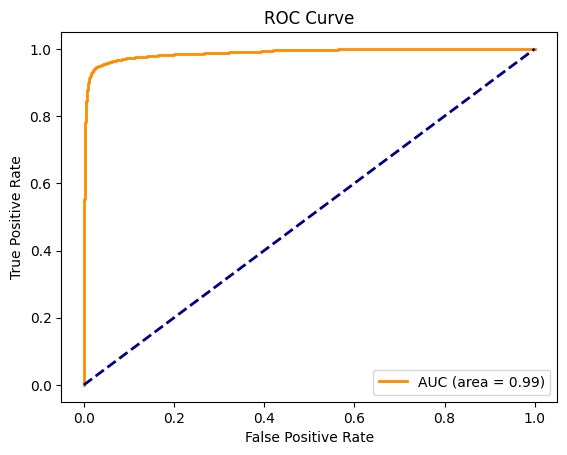

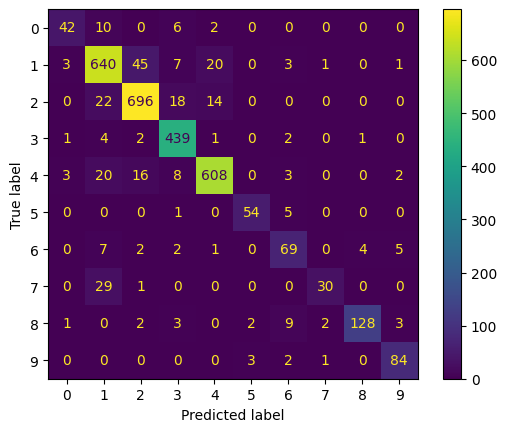

Accuracy: 0.9029126213592233
F1 Score: 0.9043141879401764
Precision: 0.9032564309103863
Recall/Sensitivity/True Positive Rate: 0.9029126213592233
Area under ROC curve: 0.9838182783371044
Confusion Matrix:
 [[ 42  10   0   6   2   0   0   0   0   0]
 [  3 640  45   7  20   0   3   1   0   1]
 [  0  22 696  18  14   0   0   0   0   0]
 [  1   4   2 439   1   0   2   0   1   0]
 [  3  20  16   8 608   0   3   0   0   2]
 [  0   0   0   1   0  54   5   0   0   0]
 [  0   7   2   2   1   0  69   0   4   5]
 [  0  29   1   0   0   0   0  30   0   0]
 [  1   0   2   3   0   2   9   2 128   3]
 [  0   0   0   0   0   3   2   1   0  84]]


In [27]:
# get random search best model results
get_metrics(rs_clf, x_test_norm, y_test)

Since RandomSearchCV is not exhaustive, it was unable to find an improvement to our previous models.

In [18]:
# wrap MLPClassifier in GridSearchCV

from sklearn.model_selection import GridSearchCV

def mlp_grid_search(clf):

    # dictionary of parameters to be varied (keys), and arrays of possible values (values)
    param_grid = {
        # number of layers and their sizes
        "hidden_layer_sizes": [(8,), (10,), (12,), (10, 10)],
        # activation functions
        "activation": ["identity", "tanh", "relu"],
        # learning rate
        "learning_rate_init": [0.001, 0.005],
        # max number of epochs
        "max_iter": [300, 400],
        # momentum
        "momentum": [0.8, 0.9],
        # tolerance
        "tol": [0.01, 0.001, 0.0001]
    }

    return GridSearchCV(estimator=clf, param_grid=param_grid)

In [ ]:
# perform gridsearch

# initialize classifier for grid search
mlp_clf = MLPClassifier(
    random_state=42,
    solver="sgd"
)

# get best classifier (with gridsearch results)
gs_clf = mlp_grid_search(mlp_clf)

# train classifier
gs_clf.fit(x_train_norm, y_train.to_numpy().ravel())

In [ ]:
# get gridsearch best model results
get_metrics(gs_clf, x_test_norm, y_test)

# CNNs

In [ ]:
# CNNs
# theres no cnn in scikit, gotta use tensorflow (keras)
# https://www.tensorflow.org/tutorials/images/cnn

from keras import datasets, layers, models
import pandas as pd
import numpy as np

model = models.Sequential()

In [ ]:
x_train_org = pd.read_csv('CompleteDataset/x_train_all.csv')
y_train_org = pd.read_csv('CompleteDataset/y_train_all.csv')
x_test_org = pd.read_csv('CompleteDataset/x_test_all.csv')
y_test_org = pd.read_csv('CompleteDataset/y_test_all.csv')

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
# reshaped data to be a 2-D input 
reshaped_train_data = np.array(X_train).reshape(-1, 48, 48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48, 48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
model = models.Sequential()
# add two convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# flatten and add two dense (fully connected)layers and apply softmax on the output
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))
# compile model with sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
# train model
model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)
# evalute and obatain accuracy
_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"Accuracy {accuracy}")



Accuracy 0.9747161865234375


#### CNN on test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_test_org, y_test_org, test_size=0.2, random_state=42)


In [ ]:
# reshaped data to be a 2-D input 
reshaped_train_data = np.array(X_train).reshape(-1, 48, 48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48, 48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
model = models.Sequential()
# add two convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# flatten and add two dense (fully connected)layers and apply softmax on the output
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))
# compile model with sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
# train model
model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)
# evalute and obatain accuracy
_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"Accuracy {accuracy}")



Accuracy 0.9757281541824341


#### K-Fold

In [ ]:
from sklearn.model_selection import KFold,StratifiedKFold
# function to do 10-Fold cross validation
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def doKfold(data, labels):
    print("Started...")
    accuracies = []
    # Iterate over each fold
    for i, (train_index, test_index) in enumerate(kfold.split(data,labels)):

        # Split data into training and testing sets 
        train_data, test_data = data[train_index], data[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]
        train_data = np.array(train_data).reshape(-1,48,48,1)
        test_data = np.array(test_data).reshape(-1,48,48,1)

        model = models.Sequential()
        # add two convolutional and pooling layers

        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        # flatten and add two dense (fully connected)layers and apply softmax on the output
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(10,activation="softmax"))
        # Compile the model
        model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        # Train the model
        model.fit(train_data, train_labels, epochs=5, verbose=0)
        # Evaluate the model 
        _, accuracy = model.evaluate(test_data, test_labels, verbose=0)
        print(f"Accuracy on fold {i + 1}: {accuracy}")

        # append accuracies
        accuracies.append(accuracy)

    # Obtain average accuracy
    average_accuracy = np.mean(accuracies)
    print(f"\nAverage accuracy: {average_accuracy}")
    # Plotting the cross-validation scores
    
    plt.plot(range(len(accuracies)), accuracies)
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Cross-Validation Scores')
    plt.ylim(0, 1)  # Set the y-axis limits if needed
    plt.show()

In [ ]:
reshaped_train_data = np.array(x_train_org).reshape(-1, 48, 48, 1)
reshaped_train_labels = np.array(y_train_org)
reshaped_test_data = np.array(x_test_org).reshape(-1, 48, 48, 1)
reshaped_test_labels = np.array(y_test_org)

##### On the train set

Started...
Accuracy on fold 1: 0.9649122953414917
Accuracy on fold 2: 0.9525283575057983
Accuracy on fold 3: 0.9638803005218506
Accuracy on fold 4: 0.9494324326515198
Accuracy on fold 5: 0.9711042046546936
Accuracy on fold 6: 0.9855521321296692
Accuracy on fold 7: 0.9649122953414917
Accuracy on fold 8: 0.9803921580314636
Accuracy on fold 9: 0.9628483057022095
Accuracy on fold 10: 0.9711042046546936

Average accuracy: 0.9666666686534882


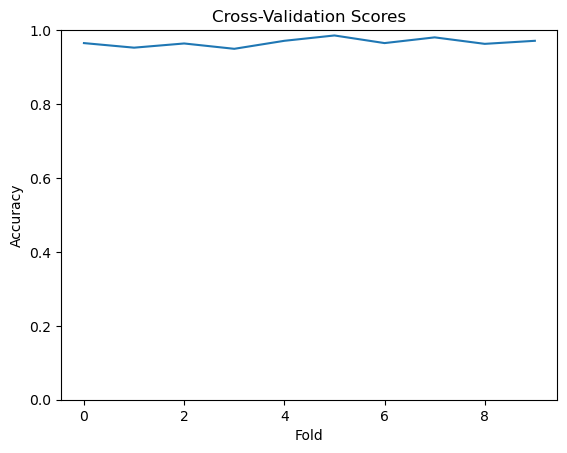

In [ ]:
# perform 10-fold cross validation on the train set
doKfold(np.array(x_train_org),np.array(y_train_org))

##### On test data

Started...
Accuracy on fold 1: 0.9514563083648682
Accuracy on fold 2: 0.9676375389099121
Accuracy on fold 3: 0.9676375389099121
Accuracy on fold 4: 0.9676375389099121
Accuracy on fold 5: 0.9288026094436646
Accuracy on fold 6: 0.9708737730979919
Accuracy on fold 7: 0.9514563083648682
Accuracy on fold 8: 0.9061488509178162
Accuracy on fold 9: 0.9417475461959839
Accuracy on fold 10: 0.9579287767410278

Average accuracy: 0.9511326789855957


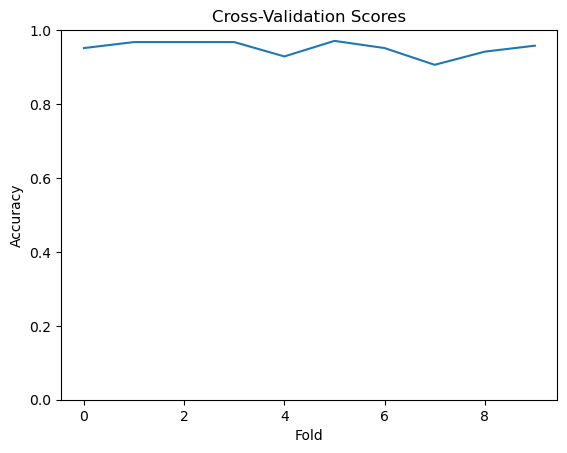

In [ ]:
# perform 10-fold cross validation on the test set
doKfold(np.array(x_test_org),np.array(y_test_org))

#### Changing Parameters

##### Different Activation functions

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
reshaped_train_data = np.array(X_train).reshape(-1, 48, 48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48, 48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
# for each function in the list
for act_func in ["relu","tanh","sigmoid","softmax"]:
    # define and add layers to model as previously done
    # replace activation function with current function
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation=act_func, input_shape=(48, 48, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation=act_func))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=act_func))
    model.add(layers.Dense(64, activation=act_func))
    model.add(layers.Dense(10,activation="softmax"))

    model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

    model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

    _,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
    print(f"\nAccuracy with activation function {act_func} : {accuracy}")


    


Accuracy with activation function relu : 0.9690402746200562

Accuracy with activation function tanh : 0.23581011593341827

Accuracy with activation function sigmoid : 0.20227038860321045

Accuracy with activation function softmax : 0.23581011593341827


##### Reduced Layers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
reshaped_train_data = np.array(X_train).reshape(-1, 48, 48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48, 48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
model = models.Sequential()
# remove one convolutionallayer, one pooling layer and one fully connected layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"\nAccuracy with reduced layers: {accuracy}")


Accuracy with reduced layers: 0.9339525103569031


##### Using 1-D input

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
# shape data as 1-D input
reshaped_train_data = np.array(X_train).reshape(-1, 2304, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 2304, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
# define model as usual and evaluate accuracy
model = models.Sequential()
model.add(layers.Conv1D(32, (3), activation='relu', input_shape=(2304, 1)))
model.add(layers.MaxPooling1D((2)))
model.add(layers.Conv1D(64, (3), activation='relu'))
model.add(layers.MaxPooling1D((2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"\nAccuracy with 1-D input : {accuracy}")


Accuracy with 1-D input : 0.942208468914032


##### Without the Dense (fully connected) layers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
reshaped_train_data = np.array(X_train).reshape(-1, 48,48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48,48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
# removed 2 fully connected layers and evaluated accuracy
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"\nAccuracy without dense layers : {accuracy}")


Accuracy without dense layers : 0.9158926606178284


##### Increasing Convolutional layers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
reshaped_train_data = np.array(X_train).reshape(-1, 48,48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48,48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
# add one convolutional and pooling layer and evalutate accuracy
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"\nAccuracy with increased convolutional layers : {accuracy}")


Accuracy with increased convolutional layers : 0.9767801761627197


#### with reduced filters in each conv layer

In [ ]:
model = models.Sequential()
# reduce number of filters in the convolutional layers
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(48,48, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit(reshaped_train_data, reshaped_train_labels, epochs=5,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"\nAccuracy with reduced filters in layers : {accuracy}")


Accuracy with reduced filters in layers : 0.9711042046546936


#### Testing against entire original train and test sets

In [ ]:
reshaped_train_data = np.array(x_train_org).reshape(-1, 48,48, 1)
reshaped_train_labels = np.array(y_train_org)
reshaped_test_data = np.array(x_test_org).reshape(-1, 48,48, 1)
reshaped_test_labels = np.array(y_test_org)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(48,48, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.fit(reshaped_train_data, reshaped_train_labels, epochs=10,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"\nAccuracy with original train and test sets : {accuracy}")


Accuracy with original train and test sets : 0.9475728273391724


##### Increasing Epochs

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_train_org, y_train_org, test_size=0.2, random_state=42)


In [ ]:
reshaped_train_data = np.array(X_train).reshape(-1, 48,48, 1)
reshaped_train_labels = np.array(y_train)
reshaped_test_data = np.array(X_test).reshape(-1, 48,48, 1)
reshaped_test_labels = np.array(y_test)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
# increase number of epochs to 10
model.fit(reshaped_train_data, reshaped_train_labels, epochs=10,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"Accuracy with 10 epochs {accuracy}")



Accuracy with 10 epochs 0.9772961735725403


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
# increase number of epochs to 15
model.fit(reshaped_train_data, reshaped_train_labels, epochs=15,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"Accuracy with 15 epochs {accuracy}")



Accuracy with 15 epochs 0.9850361347198486


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation="softmax"))

model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
# increase number of epochs to 20
model.fit(reshaped_train_data, reshaped_train_labels, epochs=20,validation_data=(reshaped_test_data, reshaped_test_labels),verbose=0)

_,accuracy = model.evaluate(reshaped_test_data, reshaped_test_labels,verbose=0)
print(f"Accuracy with 20 epochs {accuracy}")



Accuracy with 20 epochs 0.9778121709823608
